In [1]:
from __future__ import print_function, division

#importing pandas for reading and parsing of tabulated data
import pandas as pd
#importing geopandas read to plot geographical information
import geopandas as gpd
#importing fiona to handle geographical coordinates
import fiona
#import shapely to handle geographical shapes
import shapely
import requests
import urllib
import pylab as pl
%pylab inline
import json
import os
import io

Populating the interactive namespace from numpy and matplotlib


## 1. PUMA : Public Use Microdata Area

In [2]:
url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile"

urllib.request.urlretrieve(url, "puma.zip")

os.system("unzip -d %s puma.zip"%(os.getenv("PUIDATA")))

0

In [4]:
filename = os.getenv('PUIDATA') + '/PUMA'

cens_key = open(os.getenv('PUIDATA')+'/census_key.txt', 'r+')
myAPI = cens_key.readlines()[0]


In [5]:
pumashp = gpd.GeoDataFrame.from_file(filename)
pumashp.head()

,shape_area,shape_leng,puma,geometry
0,9.792852e+07,53227.144357,3701,POLYGON ((-73.89641133483133 40.90450452082026...
1,1.889860e+08,106050.002507,3702,POLYGON ((-73.86477258283533 40.90201244187379...
2,2.670137e+08,304070.209400,3703,(POLYGON ((-73.78833349834532 40.8346671297593...
3,1.062129e+08,47970.901277,3704,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,1.224950e+08,68630.512052,3705,POLYGON ((-73.88753429505171 40.82250933946978...


In [6]:
pumashp.crs

{'init': 'epsg:4326'}

Text(0.5,1,'NYC PUMA')

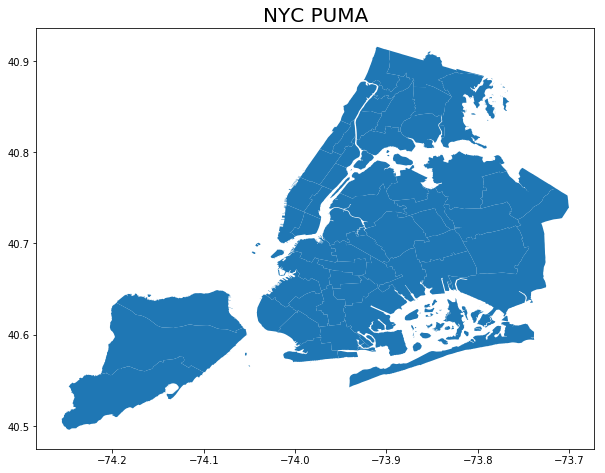

In [7]:
pumashp.plot(figsize=(10,10))
plt.title("NYC PUMA",fontsize=20)

Figure. New York City Public Use Microdata Areas

## 2. American Fact Finder data on percentage of houses with broadband internet access

In [9]:
#import censusAPI 



In [11]:
#key = censusAPI.getkey()
key = myAPI
#key

In [12]:
#read in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [13]:
#turning things into arrays to enable broadcasting
#Python3
affkeys = np.array(list(aff1y['variables'].keys()))

In [14]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type')]

In [15]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [16]:
#keyword for the number of households with broarband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [17]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + key
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [18]:
#getting the first row of the table: the total number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + key
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [19]:
pumaBB = pumaBB.merge(pumaPP[['B28002_001E','NAME']],on='NAME')
pumaBB['pcBB'] = (pumaBB['B28002_004E'] / pumaBB['B28002_001E']) * 100
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,61146,78.150656


In [20]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])
bbpc = bbpc.rename(columns={'GCT_STUB.target-geo-id2': 'gid'})
bbpc["gid"] = bbpc.gid - 3600000

bbpc.head()

TypeError: unsupported operand type(s) for -: 'str' and 'int'

In [21]:
diff_ = pumaBB.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["pcBB", "HC01"]]

diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"].astype(float))

diff_.describe()

,pcBB,diff
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


In [22]:
pumashp['puma'] = pumashp['puma'].astype(int)

In [23]:
#choropleth of the percentage of internet access
pumashp = pumashp.merge(pumaBB, left_on='puma',right_on='public use microdata area')
pumashp.head()

,shape_area,shape_leng,puma,geometry,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,B28002_001E,pcBB
0,9.792852e+07,53227.144357,3701,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,42158,84.275820
1,1.889860e+08,106050.002507,3702,POLYGON ((-73.86477258283533 40.90201244187379...,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,49817,68.310015
2,2.670137e+08,304070.209400,3703,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,44329,82.826141
3,1.062129e+08,47970.901277,3704,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,44476,72.553737
4,1.224950e+08,68630.512052,3705,POLYGON ((-73.88753429505171 40.82250933946978...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,58706,69.425612


## 3. Plot a choropleth of NYC broadband access

Text(0.5,1,'Broadband Access in NYC')

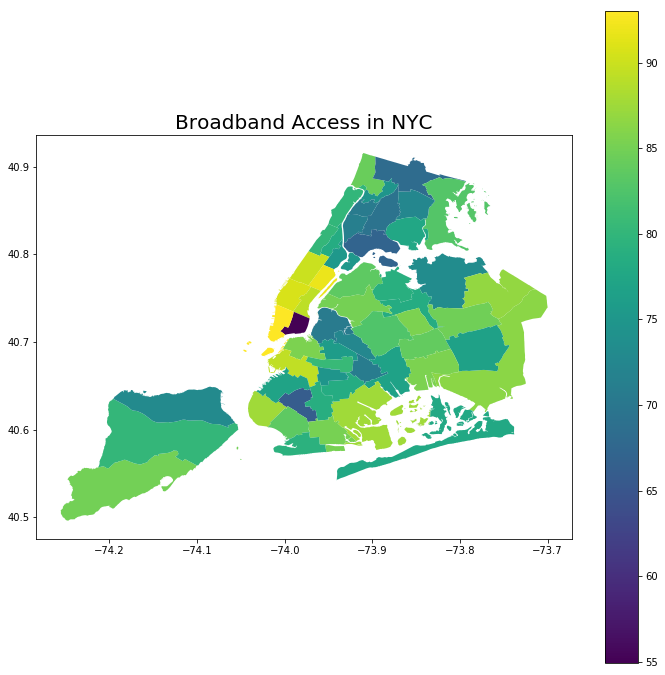

In [24]:
pumashp.plot(column='pcBB',figsize=(12,12),legend=True)
plt.title("Broadband Access in NYC",fontsize=20)

Figure. The percentage of households with access to broadband by Public Use Microdata Areas. A noticeable high low disparity occurs in lower Manhattan.

## 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

In [25]:
linkNYC = pd.read_csv("https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW9_fb55/linkNYClocations.csv")
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [26]:
linkNYC.dropna(axis=0, subset=['latitude','longitude'], inplace=True)
linkNYC['lonlat'] = list(zip(linkNYC.longitude, linkNYC.latitude))
linkNYC['geometry'] = linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude,lonlat,geometry
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [27]:
crs = {'init' : 'epsg:4326'}

In [28]:
linkshp = gpd.GeoDataFrame(linkNYC,crs=crs)

In [29]:
linkshp['date_link_'] = pd.to_datetime(linkshp['date_link_'])

Text(0.5,1,'NYC Broadband Access and LinkNYC Kiosks')

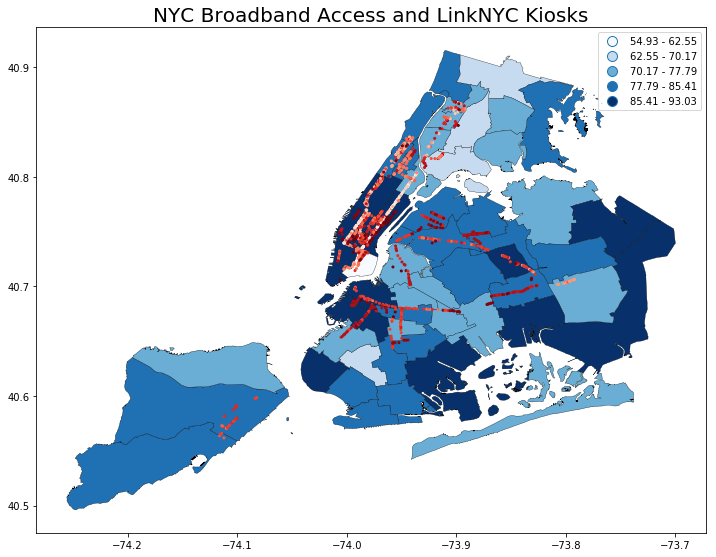

In [30]:
x = linkNYC.longitude
y = linkNYC.latitude
c = linkshp.date_link_

pumashp.plot(column='pcBB',figsize=(12,12),legend=True,scheme="equal_interval",k=5,cmap='Blues',linewidth=0.3,edgecolor='Black')
#linkshp.plot(ax=base,column='date_link_',marker='*', cmap="reds", markersize=5)

scatter(x,y,4,c,cmap="Reds")
plt.title("NYC Broadband Access and LinkNYC Kiosks", fontsize=20)


Figure. The percentage of people with broadband access mapped along with LinkNYC Kiosks color coded by date installed. PUMAs with low broadband access do not appear to have any LinkNYC Kiosks.

# 5. Find the number of linkNYC locations per person by PUMA

In [31]:
keyPop = 'B00001_001E'

url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyPop +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + key
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [32]:
pumashp = pumashp.to_crs(epsg=2263) 
linkshp = linkshp.to_crs(epsg=2263)

In [33]:
linkpp = gpd.sjoin(pumashp,linkshp).groupby('puma').count().reset_index()

linkpp = linkpp[['puma','link_site']]
linkpp.head()

,puma,link_site
0,3701,1
1,3705,1
2,3706,20
3,3707,29
4,3708,19


In [34]:
pumashplc = pumashp.merge(linkpp,on='puma',how='outer')
pumashplc.head()

,shape_area,shape_leng,puma,geometry,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,B28002_001E,pcBB,link_site
0,9.792852e+07,53227.144357,3701,"POLYGON ((1012885.033996583 268830.4841918442,...",35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,42158,84.275820,1.0
1,1.889860e+08,106050.002507,3702,"POLYGON ((1021632.335632326 267934.4393920284,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,49817,68.310015,NaN
2,2.670137e+08,304070.209400,3703,(POLYGON ((1042822.450195312 243439.8142089319...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,44329,82.826141,NaN
3,1.062129e+08,47970.901277,3704,"POLYGON ((1026308.769592285 256767.6972045382,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,44476,72.553737,NaN
4,1.224950e+08,68630.512052,3705,"POLYGON ((1015377.269592287 238959.501403747, ...",40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,58706,69.425612,1.0


In [35]:
pumashplc2 = pumashplc.merge(pumaPop,on="public use microdata area")
pumashplc2.head()

,shape_area,shape_leng,puma,geometry,B28002_004E,NAME_x,state_x,public use microdata area,Unnamed: 4_x,B28002_001E,pcBB,link_site,B00001_001E,NAME_y,state_y,Unnamed: 4_y
0,9.792852e+07,53227.144357,3701,"POLYGON ((1012885.033996583 268830.4841918442,...",35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,42158,84.275820,1.0,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,NaN
1,1.889860e+08,106050.002507,3702,"POLYGON ((1021632.335632326 267934.4393920284,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,49817,68.310015,NaN,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,NaN
2,2.670137e+08,304070.209400,3703,(POLYGON ((1042822.450195312 243439.8142089319...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,44329,82.826141,NaN,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,NaN
3,1.062129e+08,47970.901277,3704,"POLYGON ((1026308.769592285 256767.6972045382,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,44476,72.553737,NaN,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,NaN
4,1.224950e+08,68630.512052,3705,"POLYGON ((1015377.269592287 238959.501403747, ...",40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,58706,69.425612,1.0,2011,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,NaN


In [36]:
pumashplc2["linkNYCp100p"] = (pumashplc2['link_site'] / pumashplc2['B00001_001E']) * 100 
pumashplc2.head()

,shape_area,shape_leng,puma,geometry,B28002_004E,NAME_x,state_x,public use microdata area,Unnamed: 4_x,B28002_001E,pcBB,link_site,B00001_001E,NAME_y,state_y,Unnamed: 4_y,linkNYCp100p
0,9.792852e+07,53227.144357,3701,"POLYGON ((1012885.033996583 268830.4841918442,...",35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,42158,84.275820,1.0,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,NaN,0.065920
1,1.889860e+08,106050.002507,3702,"POLYGON ((1021632.335632326 267934.4393920284,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,49817,68.310015,NaN,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,NaN,NaN
2,2.670137e+08,304070.209400,3703,(POLYGON ((1042822.450195312 243439.8142089319...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,44329,82.826141,NaN,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,NaN,NaN
3,1.062129e+08,47970.901277,3704,"POLYGON ((1026308.769592285 256767.6972045382,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,44476,72.553737,NaN,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,NaN,NaN
4,1.224950e+08,68630.512052,3705,"POLYGON ((1015377.269592287 238959.501403747, ...",40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,58706,69.425612,1.0,2011,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,NaN,0.049727


In [37]:
pumashplc2["linkNYCp100p"].describe()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%            NaN
50%            NaN
75%            NaN
max      15.141540
Name: linkNYCp100p, dtype: float64

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


Text(0.5,1,'LinkNYC kiosks per 100 People in Each NYC PUMA')

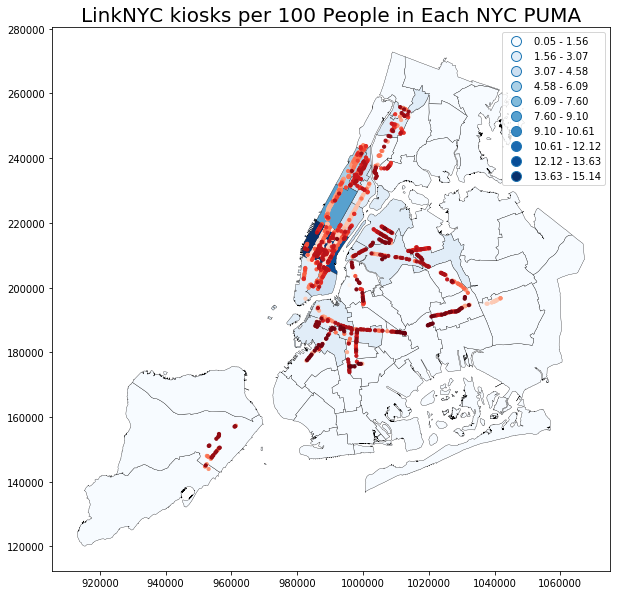

In [38]:
#x2 = linkshp.longitude
#y2 = linkshp.latitude

f, ax = plt.subplots(figsize=(10,10))

pumashplc2.plot(ax=ax,column='linkNYCp100p',figsize=(12,12),legend=True,scheme="equal_interval",k=10,cmap='Blues',linewidth=0.3,edgecolor='Black')
linkshp.plot(ax=ax,cmap='Reds',markersize=10)
plt.title("LinkNYC kiosks per 100 People in Each NYC PUMA",fontsize=20)
#scatter(x2,y2,4,c,cmap="Reds")

Figure. LinkNYC kiosks per 100 people in each NYC PUMA. Kiosks appear concentrated in midtown and upper Manhattan. 

Grade: 10/10